In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

#  Load data

In [2]:
df = pd.read_feather('data/test_tracks_only_evaluated.feather')

In [3]:
# Determine which events were assigned correctly
df['correct_assign'] = 0
index = df.query('prediction == truth').index.to_numpy() #get indices where model prediction matches true direction
df['correct_assign'][index] = 1 #events with these indices are correctly assigned

### Compute one sided confidence selections w = 2|p-1/2|. This quantity is the same whether we use p(cos(phi)) < 0 or p(cos(phi))>0

In [4]:
df['w'] = 2*np.abs(df['probneg']-1/2)

### Plot model output probability histograms
Overall, 86.2% of events are assigned with correct head-tail

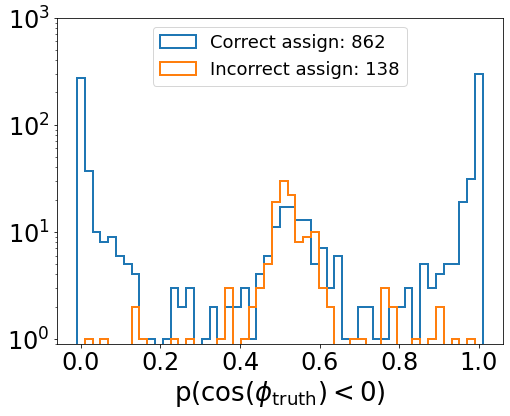

In [5]:
plt.figure(figsize = (8,6))
key = 'probneg'
plt.hist(df.query('correct_assign == 1')[key],bins = 52, range=(-0.01,1.01),label='Correct assign: %s'%(len(df.query('correct_assign == 1'))),histtype = 'step', lw = 2)
plt.hist(df.query('correct_assign == 0')[key],bins = 52, range=(-0.01,1.01),label='Incorrect assign: %s'%(len(df.query('correct_assign == 0'))),histtype = 'step', lw = 2)
plt.xlabel(r'p($\cos(\phi_\mathrm{truth}) < 0)$')
plt.legend(loc='upper center')
plt.yscale('log')
plt.ylim(0.9,1000)
plt.show()

### Optimize performance by selecting events based on w

In [6]:
wcuts = [0.01*i for i in range(0,100)]
accuracies = []
efficiencies = []
for cut in tqdm(wcuts):
    eff = len(df.query('w > %s'%(cut)))/len(df)
    acc = len(df.query('w > %s & correct_assign == 1'%(cut)))/len(df.query('w > %s'%(cut)))
    accuracies.append(acc)
    efficiencies.append(eff)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 254.48it/s]


In [7]:
effarr = np.array(efficiencies)
accarr = np.array(accuracies)
auc = effarr*accarr #If we want to maximize ROC AUC
cutidx = int(np.where(effarr < 0.7)[0][0]) # We choose to evaluate head-tail performance when keeping 70% of He events
opt_eff = effarr[cutidx]
opt_acc = effarr[cutidx]
opt_cut = wcuts[cutidx]

### Plotting the cell below shows that 99.4% of events have correct head-tail using optimized selections corresponding to us keeping 70% of our events

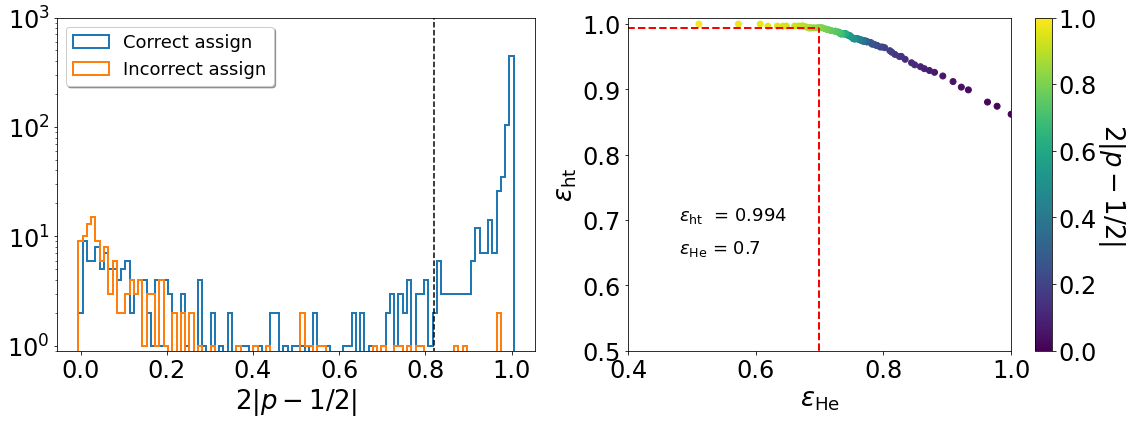

In [8]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.hist(df.query('correct_assign == 1')['w'],bins = 102, range=(-0.005,1.005),histtype = 'step', lw = 2, label = 'Correct assign')
plt.hist(df.query('correct_assign == 0')['w'],bins = 102, range=(-0.005,1.005),histtype = 'step', lw = 2, label = 'Incorrect assign')
plt.vlines(wcuts[cutidx], 0, 1e3, color = 'k', linestyle = '--')
plt.ylim(0.9,1000)
#plt.xlim(0,1)
plt.xlabel(r'$2\left|p-1/2\right|$')
plt.yscale('log')
plt.legend(loc = 'upper left', framealpha = 1, shadow = True, fancybox = True)
plt.subplot(1,2,2)
plt.scatter(efficiencies,accuracies,c=wcuts,vmin = 0, vmax =1)
#plt.vlines(effarr[int(np.where(effarr>0.5)[0][int(np.where(effarr>0.5)[0].max())])],0,accarr[int(np.where(effarr>0.5)[0][int(np.where(effarr>0.5)[0].max())])],color = 'magenta', linestyle = '--',lw=2)
#plt.hlines(accarr[int(np.where(effarr>0.5)[0][int(np.where(effarr>0.5)[0].max())])],0,effarr[int(np.where(effarr>0.5)[0][int(np.where(effarr>0.5)[0].max())])],color = 'magenta', linestyle = '--',lw=2)
cbar = plt.colorbar().set_label(r'$2\left|p-1/2\right|$',labelpad = 30, rotation = 270)
plt.vlines(efficiencies[cutidx],0,accuracies[cutidx],linestyle='--',color = 'red', lw=2)
plt.hlines(accuracies[cutidx],0,efficiencies[cutidx],linestyle='--',color = 'red', lw=2)
plt.text(0.48,0.7,r'$\varepsilon_\mathrm{ht}$  = %s'%(np.round(accuracies[cutidx],3)),size = 18)
plt.text(0.48,0.65,r'$\varepsilon_\mathrm{He}$ = %s'%(np.round(efficiencies[cutidx],2)), size = 18)
plt.ylim(0.5,1.01)
plt.xlim(0.4,1)
plt.xlabel(r'$\varepsilon_\mathrm{He}$')
plt.ylabel(r'$\varepsilon_\mathrm{ht}$')
plt.tight_layout()

### Make a grand summary plot versus energy

In [9]:
Es = np.linspace(0,500,26)

## CNN

w_cuts = []
effs = []
eff_errs = []
for i in range(1,len(Es)):
    tmp = df.query('%s < track_energy < %s'%(Es[i-1],Es[i]))
    wcut = np.quantile(tmp['w'],0.3) #selections at (1 - 0.3)*100 = 70% signal efficiency 
    eff = len(tmp.query('(w > %s) & truth == prediction'%(wcut)))/len(tmp.query('(w > %s)'%(wcut)))
    efferr = np.sqrt(eff*(1-eff)/len(tmp.query('(w > %s)'%(wcut))))
    w_cuts.append(wcut)
    effs.append(eff)
    eff_errs.append(efferr)
    
## CNN truth

w_cutst = []
effst = []
eff_errst = []
for i in range(1,len(Es)):
    tmp = df.query('%s < truth_event_energy < %s'%(Es[i-1],Es[i]))
    wcut = np.quantile(tmp['w'],0.3) #selections at (1 - 0.3)*100 = 70% signal efficiency 
    eff = len(tmp.query('(w > %s) & prediction == truth'%(wcut)))/len(tmp.query('(w > %s)'%(wcut)))
    efferr = np.sqrt(eff*(1-eff)/len(tmp.query('(w > %s)'%(wcut))))
    w_cutst.append(wcut)
    effst.append(eff)
    eff_errst.append(efferr)

### Figure in the cell below uses selections on w in each energy bin that corresponds to 70% He recoil efficiency
We get excellent event-level head-tail performance down to below 50 keV!

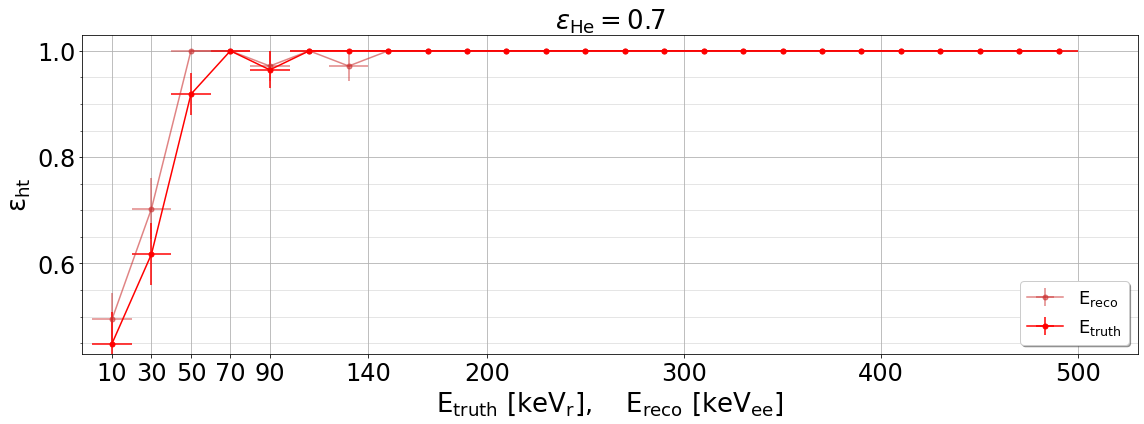

In [10]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
fig, ax = plt.subplots(1,1,figsize = (16,6))
ax.errorbar((Es+10)[:-1],effs,eff_errs,[10 for i in range(0,len(effs))],'o-',markersize = 5,color = (0.8,0.2,0.2), label = r'$\rm E_{reco}$',alpha = 0.6)
ax.errorbar((Es+10)[:-1],effst,eff_errst,[10 for i in range(0,len(effst))],'o-',markersize = 5,color = 'red', label = r'$\rm E_{truth}$')
ax.set_ylim(0.5,1.05)
ax.set_xlabel(r'$\rm E_{truth}$ $[\rm keV_{r}]$,    $\rm E_{reco}$ $[\rm keV_{ee}]$')
ax.set_ylabel(r'$\rm \varepsilon_{ht}$')
ax.set_xlim(-5,530)
ax.set_xticks([10,30,50,70,90,140,200,300,400,500])
ax.set_title(r'$\varepsilon_\mathrm{He} = 0.7$')
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.grid(which = 'major')
ax.grid(which = 'minor',alpha = 0.4)
ax.legend(shadow = True, fancybox = True, framealpha = 1, loc = 'lower right',ncol = 1)
plt.ylim(0.43,1.03)
plt.tight_layout()
plt.show()